### Фильтрация, описание, глубина фотографий

In [ ]:
!pip install -U transformers

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image, UnidentifiedImageError
import requests
from transformers import CLIPProcessor, CLIPModel, pipeline
import torch
import torchvision.transforms as transforms
from accelerate.test_utils.testing import get_backend

### Отфильтруем информативные изображжения от неинформативных с помощью Zero-Shot Image Classification, используя предобученную модель [openai/clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)

In [40]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#### Достанем ссылки на фото
`Bursa`

In [119]:
bursa = pd.read_excel('train//bursa_encoded.xlsx')
df = bursa.copy()

def extract_images_and_titles(image_link_str):
    try:
        image_data = json.loads(image_link_str)
        return [item['image'] for item in image_data]
    except json.JSONDecodeError:
        return []

df['images_links'] = df['images'].apply(extract_images_and_titles)

In [120]:
def to_correct_links(links):
    global links_lst
    lst = []
    for link in links:
        if link.startswith('https:'):
            link = link
        else:
            link = 'https:'+link
        links_lst.append(link)
        lst.append(link)
    return lst
    
links_lst = []

df['images_links'] = df['images_links'].apply(to_correct_links)

In [122]:
len(links_lst)

1553

#### Теперь отфильтруем только те, где уверенность в информативном классе более или равна 90 %

In [106]:
lst_probs = []
lst_useful_links = []
for url in links_lst:
    image = Image.open(requests.get(url, stream=True).raw)    
    inputs = processor(text=["indoor gym fitness center yoga studio pilates pool exercise room sports club with exercise equipment yoga mats mirror",
                            "building outdoors or branding sign or trees or other"],
                       images=image, return_tensors="pt", padding=True)
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    prob = round(float(logits_per_image.softmax(dim=1)[0][0]), 2)
    lst_probs.append(prob)
    if prob >= 0.9:
        lst_useful_links.append(url)

In [124]:
def to_filter_links(links):
    lst = []
    for link in links:
        if link in lst_useful_links:
            lst.append(link)
    return lst
    
df['useful_images'] = df['images_links'].apply(to_filter_links)

In [130]:
df.to_excel('train//bursa_filtered_img.xlsx', index = False)

bursa_useful_img = lst_useful_links.copy()
with open('data//bursa_useful_img.txt', 'w') as file:
    for item in bursa_useful_img:
        file.write(f"{item}\n")

print("Список сохранён в файл bursa_useful_img.txt")

Список сохранён в файл bursa_useful_img.txt


#### Достанем ссылки на фото
`Ankara`

In [131]:
ankara = pd.read_excel('train//ankara_encoded.xlsx')
df = ankara.copy()
df['images_links'] = df['images'].apply(extract_images_and_titles)

In [132]:
links_lst = []

df['images_links'] = df['images_links'].apply(to_correct_links)
len(links_lst)

3883

In [145]:
lst_probs = []
lst_useful_links = []

for url in links_lst:
    try:

        image = Image.open(requests.get(url, stream=True).raw)
        
        inputs = processor(text=["indoor gym fitness center yoga studio pilates pool exercise room sports club with exercise equipment yoga mats mirror",
                                 "building outdoors or branding sign or trees or other"],
                           images=image, return_tensors="pt", padding=True)
        
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        prob = round(float(logits_per_image.softmax(dim=1)[0][0]), 2)
        
        lst_probs.append(prob)
        
        if prob >= 0.9:
            lst_useful_links.append(url)

    except UnidentifiedImageError as e:
        print(f"Could not identify image from {url}: {e}")
        continue
    except Exception as e:
        print(f"Error processing {url}: {e}")
        continue

Error processing https://streetviewpixels-pa.googleapis.com/v1/thumbnail?panoid=kv0vd21iMbU-kwltcZoD4A&cb_client=maps_sv.tactile.gps&w=224&h=298&yaw=280.33267&pitch=0&thumbfov=100: HTTPSConnectionPool(host='streetviewpixels-pa.googleapis.com', port=443): Max retries exceeded with url: /v1/thumbnail?panoid=kv0vd21iMbU-kwltcZoD4A&cb_client=maps_sv.tactile.gps&w=224&h=298&yaw=280.33267&pitch=0&thumbfov=100 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000022903D479E0>, 'Connection to streetviewpixels-pa.googleapis.com timed out. (connect timeout=None)'))


In [148]:
def to_filter_links(links):
    lst = []
    for link in links:
        if link in lst_useful_links:
            lst.append(link)
    return lst
    
df['useful_images'] = df['images_links'].apply(to_filter_links)

In [149]:
df.to_excel('train//ankara_filtered_img.xlsx', index = False)

In [150]:
ankara_useful_img = lst_useful_links.copy()
with open('data//ankara_useful_img.txt', 'w') as file:
    for item in ankara_useful_img:
        file.write(f"{item}\n")

print("Список сохранён в файл ankara_useful_img.txt")

Список сохранён в файл ankara_useful_img.txt


#### Достанем ссылки на фото
`Istanbul`

In [151]:
istanbul = pd.read_excel('train//istanbul_encoded.xlsx')
df = istanbul.copy()
df['images_links'] = df['images'].apply(extract_images_and_titles)

In [152]:
links_lst = []

df['images_links'] = df['images_links'].apply(to_correct_links)
len(links_lst)

10141

In [153]:
import requests
from PIL import Image, UnidentifiedImageError
from transformers import CLIPProcessor, CLIPModel

lst_probs = []
lst_useful_links = []

for url in links_lst:
    try:
        # Пытаемся открыть изображение
        image = Image.open(requests.get(url, stream=True).raw)
        
        # Обработка изображения
        inputs = processor(text=["indoor gym fitness center yoga studio pilates pool exercise room sports club with exercise equipment yoga mats mirror",
                                 "building outdoors or branding sign or trees or other"],
                           images=image, return_tensors="pt", padding=True)
        
        # Получение выходных данных модели
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        prob = round(float(logits_per_image.softmax(dim=1)[0][0]), 2)
        
        lst_probs.append(prob)
        
        # Проверка уверенности
        if prob >= 0.9:
            lst_useful_links.append(url)

    except UnidentifiedImageError as e:
        # Если возникла ошибка, просто продолжаем без каких-либо действий
        print(f"Could not identify image from {url}: {e}")
        continue
    except Exception as e:
        # Ловим все остальные исключения
        print(f"Error processing {url}: {e}")
        continue

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [154]:
df['useful_images'] = df['images_links'].apply(to_filter_links)

In [156]:
df.to_excel('train//istanbul_filtered_img.xlsx', index = False)

istanbul_useful_img = lst_useful_links.copy()
with open('data//istanbul_useful_img.txt', 'w') as file:
    for item in istanbul_useful_img:
        file.write(f"{item}\n")

print("Список сохранён в файл istanbul_useful_img.txt")

Список сохранён в файл istanbul_useful_img.txt


## Все 3 города: Bursa, Ankara, Istanbul

In [200]:
cities_encoded = pd.read_excel('train//cities_encoded.xlsx')
cities_encoded['images_links'] = cities_encoded['images'].apply(extract_images_and_titles)

In [201]:
lst_useful_links = istanbul_useful_img + ankara_useful_img + bursa_useful_img
with open('data//cities_useful_img.txt', 'w') as file:
    for item in lst_useful_links:
        file.write(f"{item}\n")

print("Список сохранён в файл cities_useful_img.txt")

Список сохранён в файл cities_useful_img.txt


In [202]:
len(lst_useful_links)

8898

In [203]:
cities_encoded['useful_images'] = cities_encoded['images_links'].apply(to_filter_links)

In [204]:
cities_encoded.to_excel('train//cities_encoded_img.xlsx', index = False)

### Применим модель, которая описывает картинки [nlpconnect/vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)

In [ ]:
def convert_to_list(image_str):
    if image_str == '[]':
        return []
    else:
        return image_str[2:-2].split("', '")

# cities_encoded = pd.read_excel('/content/drive/MyDrive/FitnessData/Кейсы/Фитнес_фото/cities_smart_depth.xlsx')

cities_encoded['useful_images'] = cities_encoded['useful_images'].apply(convert_to_list)

In [319]:
pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

In [ ]:
def to_text(links):
    global total
    total += 1
    if total % 500 == 0:
        print(total)
    lst = []
    global text_lst
    for link in links:
        try:
            text = pipe(Image.open(requests.get(link, stream=True).raw))[0]['generated_text']
            lst.append(text)
        except UnidentifiedImageError as e:
            print(f"Could not identify image from {link}: {e}")
            continue
        except Exception as e:
            print(f"Error processing {link}: {e}")
            continue
    if len(lst) == 0:
        text_lst.append([])
    else:
        text_lst.append(lst)
total = 0
text_lst = []
cities_encoded['useful_images'].apply(to_text)

In [ ]:
def to_clear(text):
    text  =  text.replace('[', ' ')
    text  =  text.replace(']', '')
    text  =  text.replace(" '", ", ")
    text  =  text.replace(" '", "")
    text  =  text.replace("'", "")
    text  =  text.replace(",, ", "")
    return text[:-1]
    
cities_encoded['text_descriptions'] = cities_encoded['category'] + cities_encoded['text_descriptions']
cities_encoded['text_descriptions'] = cities_encoded['text_descriptions'].apply(to_clear)

### Применим модель, которая считает глубину [depth-anything/Depth-Anything-V2-Base-hf](https://huggingface.co/depth-anything/Depth-Anything-V2-Base-hf)

In [7]:
def convert_to_list(image_str):
    if image_str == '[]':
        return []
    else:
        return image_str[2:-2].split("', '")

cities_encoded = pd.read_excel('train/cities_smart_depth.xlsx')
cities_encoded['useful_images'] = cities_encoded['useful_images'].apply(convert_to_list)

In [6]:
device, _, _ = get_backend()
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [8]:
link = cities_encoded['useful_images'][37][1]
dictt = pipe(Image.open(requests.get(link, stream=True).raw))
maxx = round(float(dictt['predicted_depth'].max()), 2)
minn = round(float(dictt['predicted_depth'].min()))
ten = maxx - dictt['predicted_depth']
line_34 = ten[ten.shape[0]//4*3]
line_12 = ten[ten.shape[0]//2]
line_14 = ten[ten.shape[0]//4]
vert_right = ten[:,0]
vert_middle = ten[:,ten.shape[1]//2]
vert_left = ten[:,-1]

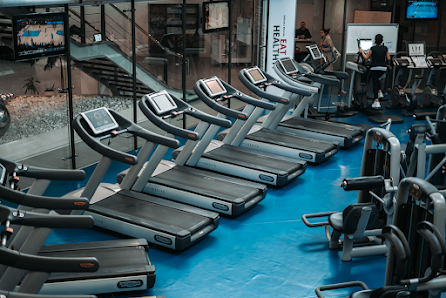

In [9]:
Image.open(requests.get(link, stream=True).raw)

C:\Users\Mariia\AppData\Local\Temp\ipykernel_24904\1881733482.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


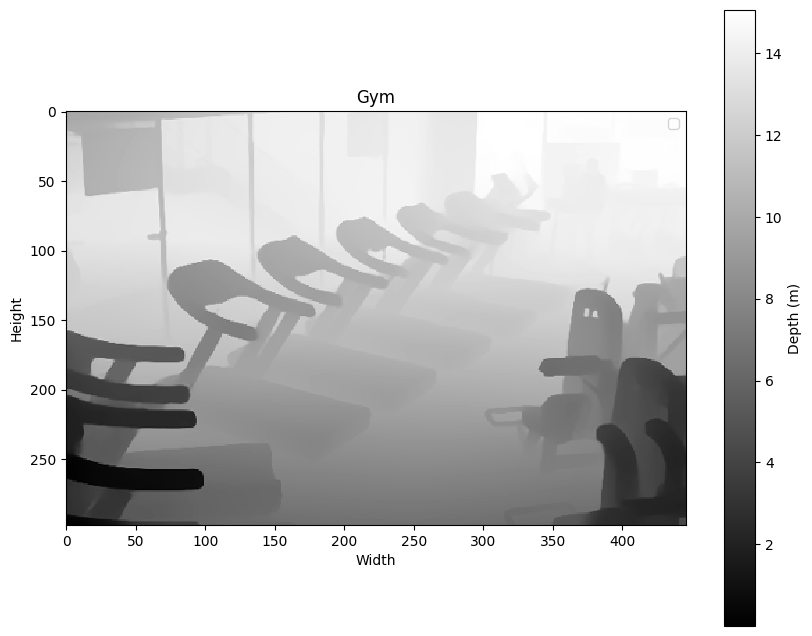

In [19]:
plt.figure(figsize=(10, 8))
plt.imshow(ten, cmap='gray', interpolation='none')
plt.colorbar(label='Depth (m)')
plt.title(f'{cities_encoded['category'][37].capitalize()}')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()

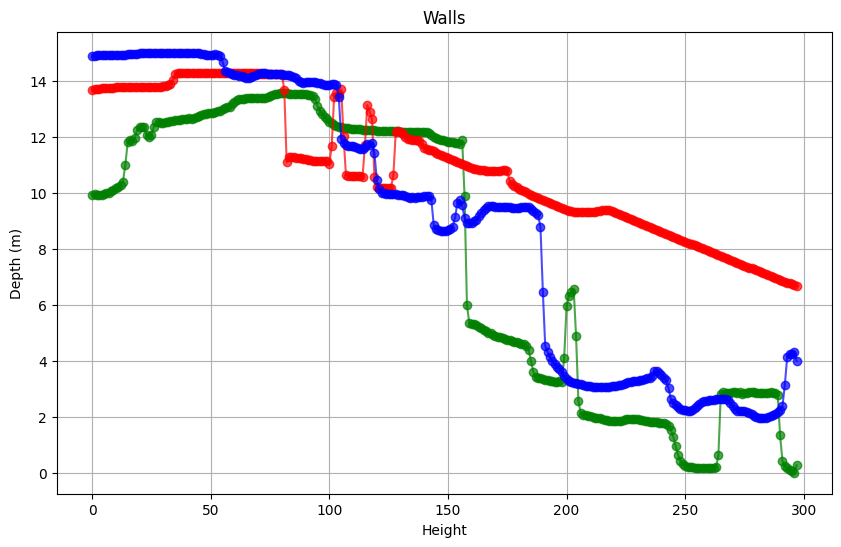

In [17]:
x_values = np.arange(len(vert_right))

plt.figure(figsize=(10, 6))
plt.plot(x_values, vert_right, marker='o', color='green', linestyle='-', alpha=0.7)
plt.plot(x_values, vert_middle, marker='o', color='red', linestyle='-', alpha=0.7)
plt.plot(x_values, vert_left, marker='o', color='blue', linestyle='-', alpha=0.7)
plt.title('Walls')
plt.xlabel('Height')
plt.ylabel('Depth (m)')

plt.grid()
plt.show()


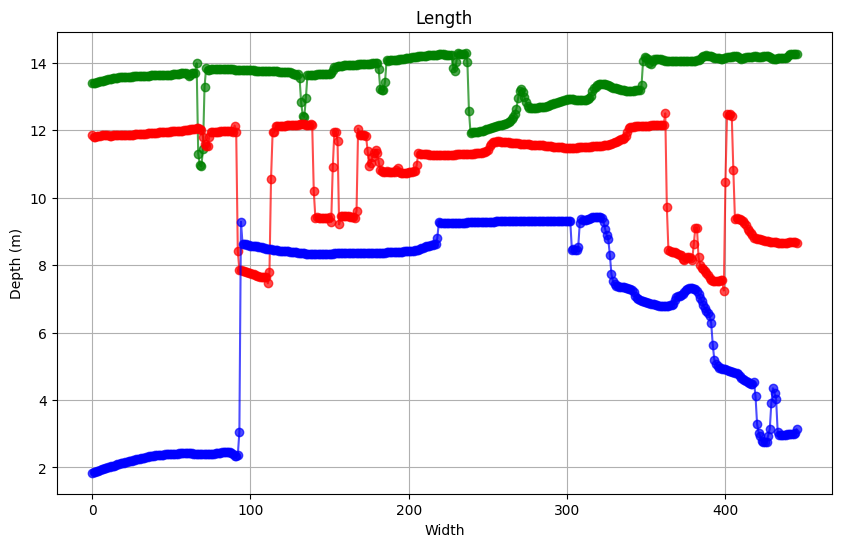

In [18]:
x_values = np.arange(len(line_12))

plt.figure(figsize=(10, 6))
plt.plot(x_values, line_14, marker='o', color='green', linestyle='-', alpha=0.7)
plt.plot(x_values, line_12, marker='o', color='red', linestyle='-', alpha=0.7)
plt.plot(x_values, line_34, marker='o', color='blue', linestyle='-', alpha=0.7)

plt.title('Length')
plt.xlabel('Width')
plt.ylabel('Depth (m)')

plt.grid()
plt.show()

In [ ]:
def to_depth(links):
    global total
    total += 1
    if total % 500 == 0:
        print(total)
    lst = []
    global depth_lst
    for link in links:
        try:
            dictt = pipe(Image.open(requests.get(link, stream=True).raw))
            maxx = float(dictt['predicted_depth'].max())
            ten = maxx - dictt['predicted_depth']
            lst.append(ten)
        except UnidentifiedImageError as e:
            print(f"Could not identify image from {link}: {e}")
            continue
        except Exception as e:
            print(f"Error processing {link}: {e}")
            continue
    depth_lst[total] = lst


total = 0
depth_lst = {}
cities_encoded['useful_images'].apply(to_depth)
print('DONE')

In [ ]:
# with open('/content/drive/MyDrive/FitnessData/Кейсы/Фитнес_фото/depth_tensors_lst.txt', 'w') as file:
#     for item in depth_lst:
#         file.write(f"{item}\n")

# print("Список сохранён в файл depth_tensors_lst.txt")

In [ ]:
depth_stats = []
for key, values in depth_lst.items():
  lst = []
  if len(values)>0:
    for ten in values:
      height = ten.shape[0]
      width = ten.shape[1]
      maxx = round(float(ten.max()), 4)
      floor_14_max = round(float(ten[height//4].max()), 4)
      floor_12_max = round(float(ten[height//2].max()), 4)
      floor_34_max = round(float(ten[height//4*3].max()), 4)
      wall_14_max = round(float(ten[:, width//4].max()), 4)
      wall_12_max = round(float(ten[:, width//2].max()), 4)
      wall_34_max = round(float(ten[:, width//4*3].max()), 4)

      floor_14_p = round(float(len(ten[height//4][ten[height//4]>floor_14_max-1.5])/width), 4)
      floor_12_p = round(float(len(ten[height//2][ten[height//2]>floor_12_max-1.5])/width), 4)
      floor_34_p = round(float(len(ten[height//4*3][ten[height//4*3]>floor_34_max-1.5])/width), 4)
      wall_14_p = round(float(len(ten[:, width//4][ten[:, width//4]>floor_14_max-1.5])/height), 4)
      wall_12_p = round(float(len(ten[:, width//2][ten[:, width//2]>floor_12_max-1.5])/height), 4)
      wall_34_p = round(float(len(ten[:, width//4*3][ten[:, width//4*3]>floor_34_max-1.5])/height), 4)

      floor_14_std = round(float(ten[height//4].std()), 4)
      floor_12_std = round(float(ten[height//2].std()), 4)
      floor_34_std = round(float(ten[height//4*3].std()), 4)
      wall_14_std = round(float(ten[:, width//4].std()), 4)
      wall_12_std = round(float(ten[:, width//2].std()), 4)
      wall_34_std = round(float(ten[:, width//4*3].std()), 4)

      floor_14_sum_norm = round(float(ten[height//4].sum()/width), 4)
      floor_12_sum_norm = round(float(ten[height//2].sum()/width), 4)
      floor_34_sum_norm = round(float(ten[height//4*3].sum()/width), 4)
      wall_14_sum_norm = round(float(ten[:, width//4].sum()/height), 4)
      wall_12_sum_norm = round(float(ten[:, width//2].sum()/height), 4)
      wall_34_sum_norm = round(float(ten[:, width//4*3].sum()/height), 4)


      lst.append([maxx, floor_14_max, floor_12_max, floor_34_max,
                  wall_14_max, wall_12_max, wall_34_max,
                  floor_14_p, floor_12_p, floor_34_p,
                  wall_14_p, wall_12_p, wall_34_p,
                  floor_14_std, floor_12_std, floor_34_std,
                  wall_14_std, wall_12_std, wall_34_std,
                  floor_14_sum_norm, floor_12_sum_norm, floor_34_sum_norm,
                  wall_14_sum_norm , wall_12_sum_norm , wall_34_sum_norm])
  depth_stats.append(lst)

In [ ]:
# with open('/content/drive/MyDrive/FitnessData/Кейсы/Фитнес_фото/depth_stats_lst.txt', 'w') as file:
#     for item in depth_stats:
#         file.write(f"{item}\n")

# print("Список сохранён в файл depth_stats_lst.txt")

In [ ]:
import numpy as np
itog = []
for line in depth_stats:
  if len(line)>0:
    id = int(np.argmax(np.array(line)[:,0]))
    itog.append(line[id])
  else:
    itog.append([np.nan for i in range(25)])

In [ ]:
cities_encoded[['maxx', 'floor_14_max', 'floor_12_max', 'floor_34_max',
                  'wall_14_max', 'wall_12_max', 'wall_34_max',
                  'floor_14_p', 'floor_12_p', 'floor_34_p',
                  'wall_14_p', 'wall_12_p', 'wall_34_p',
                 'floor_14_std', 'floor_12_std', 'floor_34_std',
                  'wall_14_std', 'wall_12_std', 'wall_34_std',
                  'floor_14_sum_norm', 'floor_12_sum_norm', 'floor_34_sum_norm',
                  'wall_14_sum_norm', 'wall_12_sum_norm', 'wall_34_sum_norm']] = itog

In [ ]:
# cities_encoded.to_excel('/content/drive/MyDrive/FitnessData/Кейсы/Фитнес_фото/cities_lines_depth.xlsx', index = False)

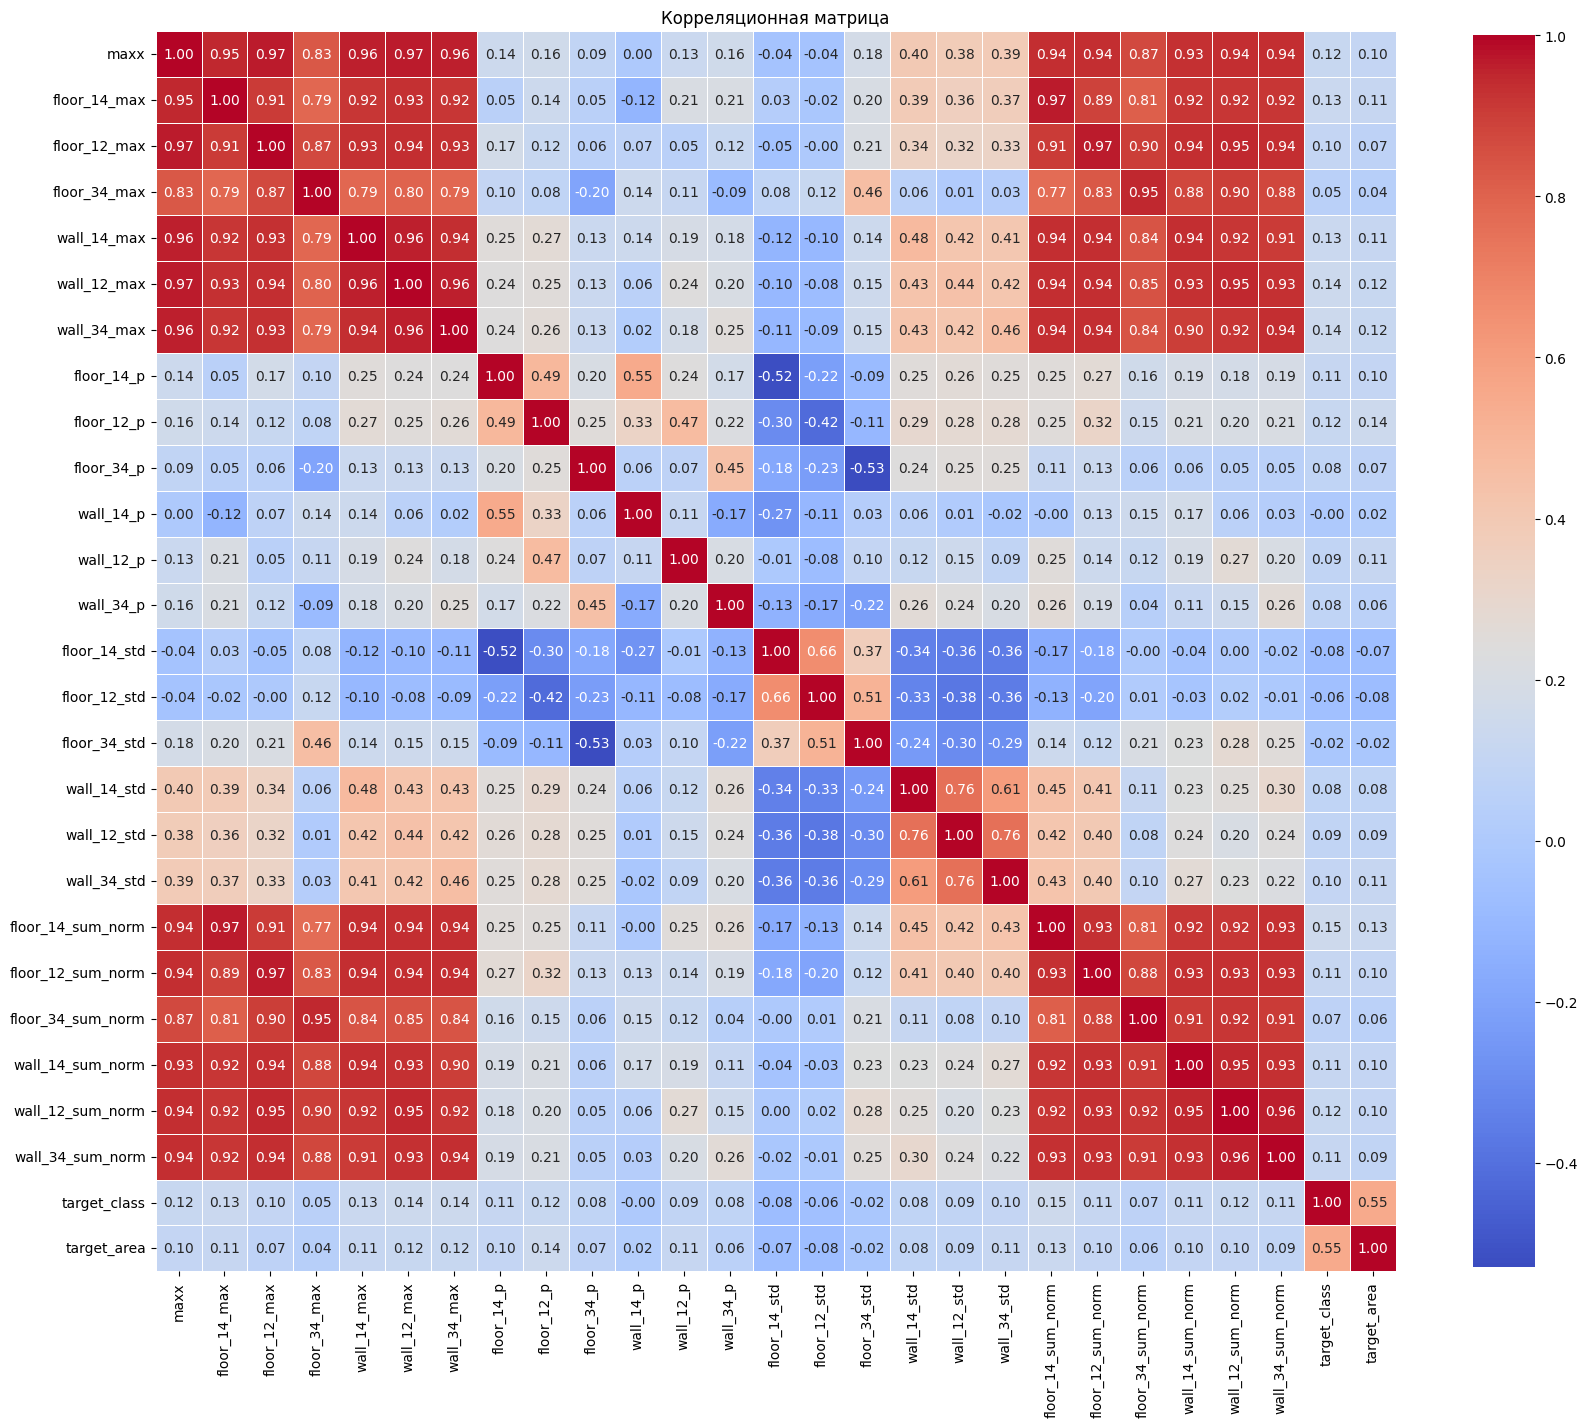

In [2]:
df = cities_encoded.copy()
correlation_matrix = round(df[['maxx', 'floor_14_max', 'floor_12_max', 'floor_34_max',
                  'wall_14_max', 'wall_12_max', 'wall_34_max',
                  'floor_14_p', 'floor_12_p', 'floor_34_p',
                  'wall_14_p', 'wall_12_p', 'wall_34_p',
                 'floor_14_std', 'floor_12_std', 'floor_34_std',
                  'wall_14_std', 'wall_12_std', 'wall_34_std',
                  'floor_14_sum_norm', 'floor_12_sum_norm', 'floor_34_sum_norm',
                  'wall_14_sum_norm', 'wall_12_sum_norm', 'wall_34_sum_norm',
                                           'target_class', 'target_area']].corr(), 2)


plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, fmt='.2f', linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()